# next
fix test_synaptic_activation_2 to include both positive and negative

In [497]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [50,50]

import brain; import importlib; importlib.reload(brain);

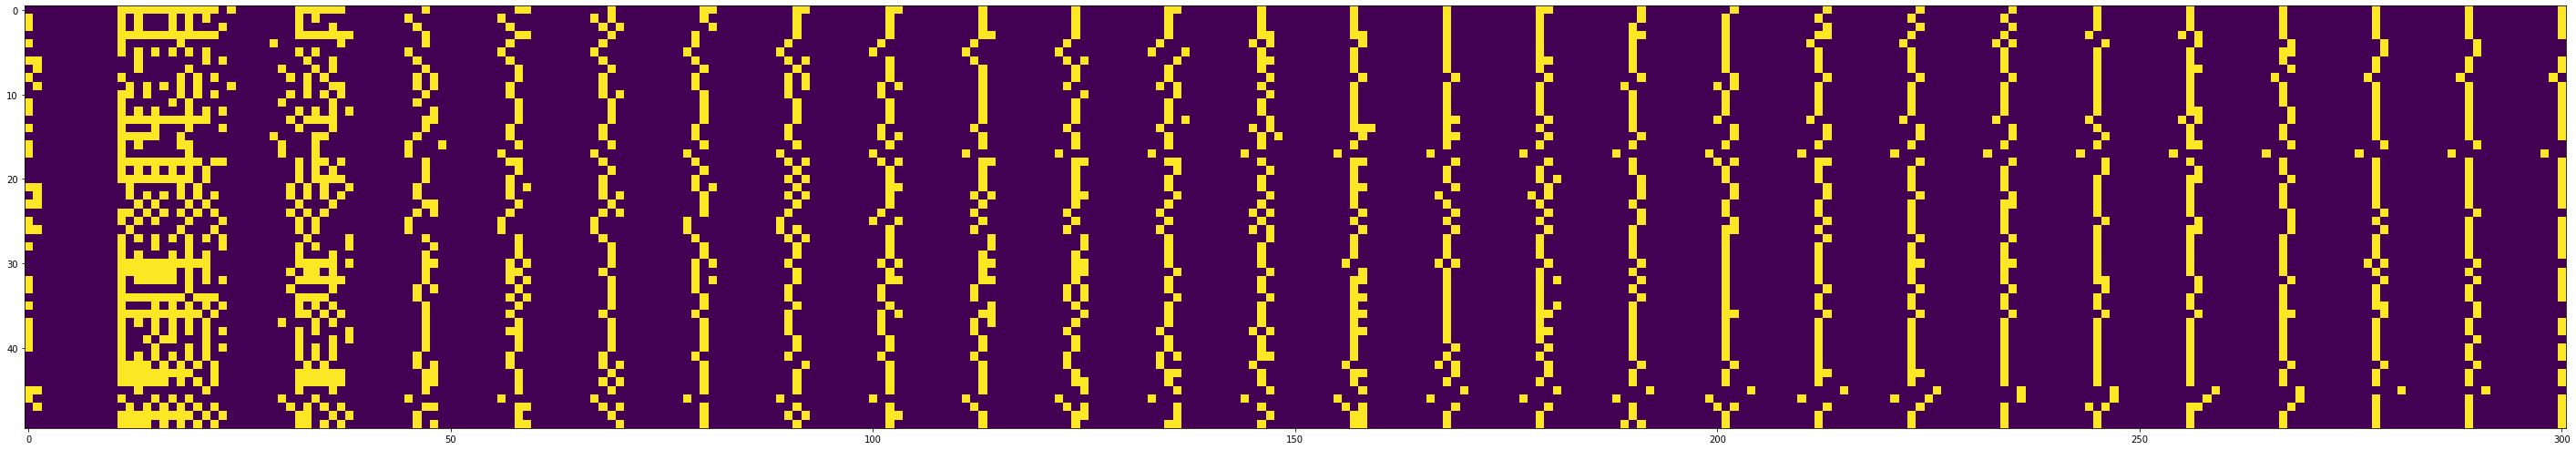

In [632]:
b = brain.Brain(
    num_neurons=50, 
    excitatory_synaptic_density=0.67,
    inhibitory_synaptic_density=0.1,
    initial_active_neuron_density=0.5,
    neuronal_max_threshold=10,
)
b.simulate_brain(300)

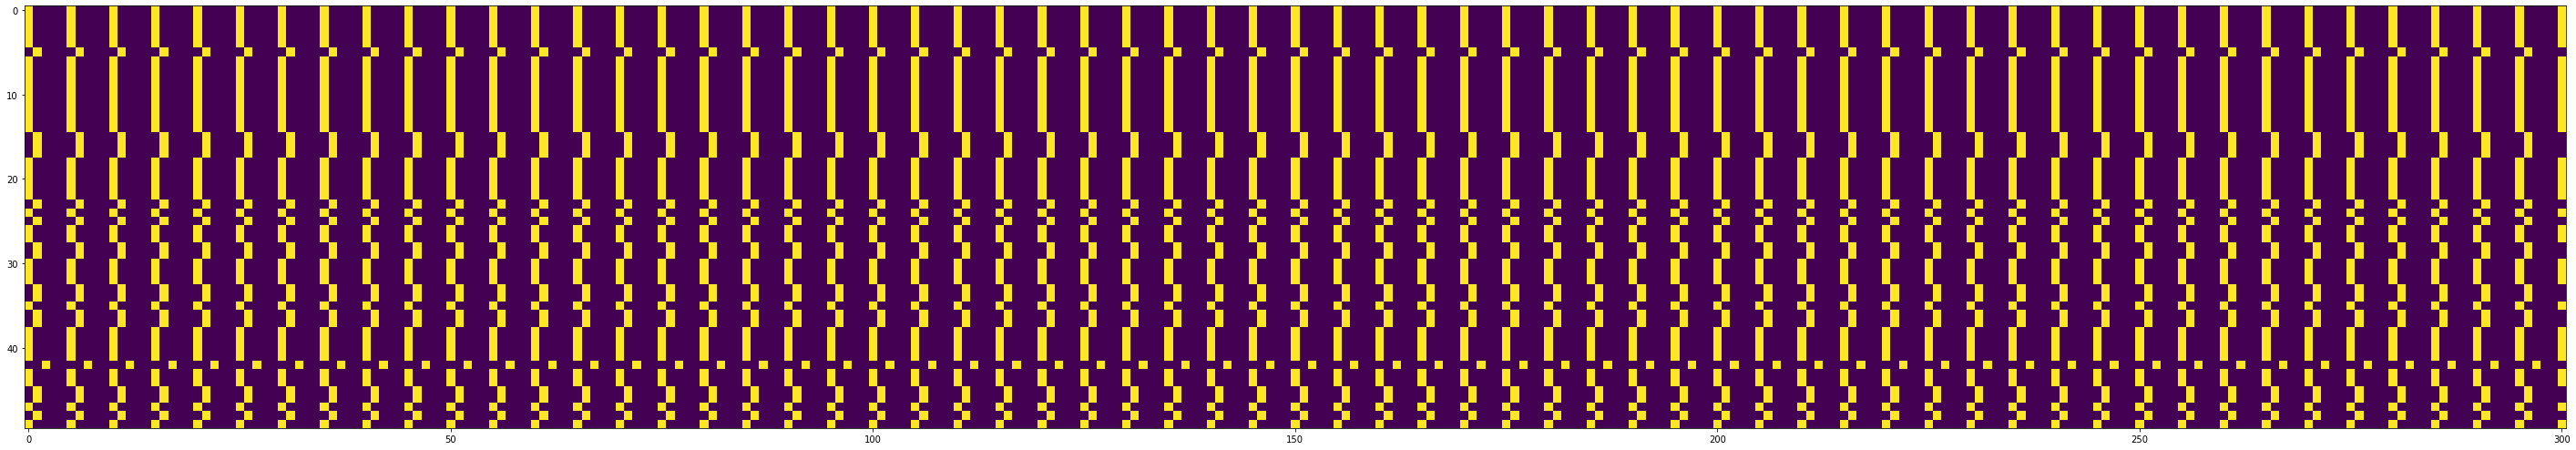

In [582]:
b.simulate_brain(300)

In [532]:
(b.synapses_a / (b.synapses_a + b.synapses_b))

<ipython-input-532-f662ffe867c0>:1: RuntimeWarning: invalid value encountered in true_divide
  (b.synapses_a / (b.synapses_a + b.synapses_b))


array([[9.99040307e-01,            nan, 1.05566219e-02, ...,
        9.59692898e-04,            nan, 9.79846449e-01],
       [9.99075786e-01, 1.01663586e-02, 1.94085028e-02, ...,
                   nan, 9.89833641e-01, 9.80591497e-01],
       [2.94676806e-02,            nan, 9.50570342e-04, ...,
        1.99619772e-02, 9.99049430e-01, 1.04562738e-02],
       ...,
       [           nan, 1.02611940e-02, 9.80410448e-01, ...,
        9.32835821e-04, 9.32835821e-04, 9.80410448e-01],
       [1.05566219e-02,            nan, 9.99040307e-01, ...,
        1.05566219e-02, 9.59692898e-04,            nan],
       [2.05479452e-02, 9.78473581e-04, 2.05479452e-02, ...,
        9.79452055e-01, 9.78473581e-04,            nan]])

# next

* get a better plot
* make the activation threshold of the neurons drain as time goes on unless they activate, then they get the max threshold

# ideas
1. represent inhibitory synapses with negative S_a
2. make faster by precalculating `self.synapses > 0` for Hebbian learning
3. make more memory efficient (maybe) by using sparse matrices

In [175]:
x = np.array([[1,2],[3,4]])

In [184]:
x[0,0:1]

array([1])

In [3]:
S = np.random.rand(1000,1000)

In [6]:
%%timeit
np.logical_not(S>0.5)

335 µs ± 43.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
np.array([[1,0],[0,1]])*(np.array([[1,2],[3,4]])>2)

array([[0, 0],
       [0, 1]])

In [10]:
import mock

ModuleNotFoundError: No module named 'mock'

In [228]:
import brain; import importlib; importlib.reload(brain);
b = brain.Brain(
        num_neurons=1,
        excitatory_synaptic_density=1,
        inhibitory_synaptic_density=0,
        neuronal_max_threshold=4,
        initial_active_neuron_density=0.5,
    )

In [233]:
b.synapses_a = -9
b.synapses_b = 1

history_length = 10000
history = []
for i in range(history_length):
    history.append(b.get_synaptic_activation())
    
sum(history)/history_length

array([[0.]])

In [493]:
self = brain.Brain(
        num_neurons=1,
        excitatory_synaptic_density=1,
        inhibitory_synaptic_density=0,
        neuronal_max_threshold=4,
        initial_active_neuron_density=0.5,
    )
syn = 0
self.synapses[0,0] = syn
self.synapses_a[0,0] = 9*syn
self.synapses_b[0,0] = 1

# average of beta distributions
synaptic_threshold = self.synapses_a / (np.abs(self.synapses_a) + self.synapses_b)

rands = np.random.rand(self.num_neurons, self.num_neurons)

# if the synapses
synaptic_activations = 1*(rands > (1-synaptic_threshold)) or -1*(-rands < -(1+synaptic_threshold))

print(synaptic_threshold)
print(rands)
print(synaptic_activations)

[[0.]]
[[0.52020867]]
[[0]]


In [494]:
np.random.rand(2,2)>np.random.rand(2,2)

array([[ True,  True],
       [ True,  True]])